In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading"> Convolutional Neural Networks to predict effectors </h1>
<div id="toc"></div>

# Overview and different approaches

## Recap on project & data

This oomycete effector recognition approach is using Convolutional Neural Networks to predict effectors.

The positive dataset (experimentally verified virulence genes) will be coming from PHI-base (Pathogen Host Interactions database), which contains many fungal/oomycete avirulence genes. The negative dataset (92 orthologous oomycete non-effector genes) represent centroid genes from a clustered dataset, in effort to make a broad representation of oomycete non-effector genes, but also keep the 1:1 ratio.

The negative dataset will contain orthologous genes from the same species of Oomycetes, using translated Open Reading Frames. These orthologous serve as a high-confidence negative dataset because effector genes are often very divergent between species, due to evolutionary pressure against plant host resistance (R) genes.

I also clustered the amino acid sequences using CD-HIT at 80% sequence identity before including them here, in effort to prevent very closely related sequences from messing with the classifier.

# Results

**Average cross validation accuracy (k=5):**

| Strawman | CNN (100aa moving averages) | CNN (200aa moving averages) | CNN (70aa OneHot) |CNN (100aa positional) |
|----------|-----------------------------|-----------------------------|-------------------| ------------------- |
| 84.25%   | 84.23%                      | 83.68%                      | 73.87%            | 71.74%|


**Full cross validation accuracies:**

| Strawman (LogReg.) | CNN (100aa moving averages) | CNN (200aa moving averages) | CNN (70aa OneHot) | CNN (100aa positional) |
|----------|-----------------------------|-----------------------------|-------------------|-------------------|
| 86.49%   | 91.89%                      | 78.38%                      | 75.68%            |75.68%|
| 81.08%   | 86.49%                      | 89.19%                      | 78.38%            |62.16%|
| 83.78%   | 81.08%                      | 86.49%                      | 67.57%            |72.97%|
| 83.78%   | 78.38%                      | 83.78%                      | 81.08%            |75.68%|
| 86.11%   | 83.33%                      | 80.56%                      | 66.67%            |72.22%|



## Features and approaches used

### Features

**features for Strawman approach (net averages inputted into Logistic Regression):**
- "GRAVY", Hydrophobicity, Exposure, Disorder, Bulkiness, Interface. 
- scaled net average feature values column-wide to 0 mean and univariance. 

**features for first attempt of CNN approach:**
- first 70 amino acids, using One Hot Encoding (2-dimensional, 1 channel)
    - minimum aminoo acid length was 70, and effectors usually have high amounts of signaling content around the N-terminal, so I decided to only look at the first 70 amino acids to not worry about padding issues.

**features for this better-tuned CNN approach**
- first 100 (also tried 200) amino acids, using various amino acid encodings (1-dimensional, 6 channels)
- "GRAVY", Hydrophobicity, Exposure, Disorder, Bulkiness, Interface.
- Encodings attempted:
    - moving averages
    - positional values

**labels:**
- 0: non-effector ooomycete avirulence gene
- 1: effector oomycete avirulence gene


### Various CNN architectures tested (for aa scale moving averages, 6 channels approach):

In [32]:
model1 = models.Sequential()

model1.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(650, activation='relu'))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(2, activation='softmax'))

model1.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 91, 32)            1952      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1440)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 650)               936650    
_________________________________________________________________
dropout_3 (Dropout)          (None, 650)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [33]:
model2 = models.Sequential()

model2.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(layers.Conv1D(32, kernel_size=(6),activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(2, activation='softmax'))

model2.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 91, 32)            1952      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 45, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 40, 32)            6176      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               128100    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

In [35]:
model3 = models.Sequential()

model3.add(layers.Conv1D(100, 10, activation='relu', input_shape=(100,6)))
model3.add(layers.Conv1D(100, 10, activation='relu'))
model3.add(layers.MaxPooling1D(3))
model3.add(layers.Conv1D(160, 5, activation='relu'))
model3.add(layers.Conv1D(160, 5, activation='relu'))
model3.add(layers.GlobalAveragePooling1D())
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(2, activation='softmax'))

model3.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 91, 100)           6100      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 82, 100)           100100    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 27, 100)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 23, 160)           80160     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 19, 160)           128160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 160)              

### (high accuracy) training history of the CNN using moving averages (84% average cross-val accuracy):

In [ ]:
# build CNN model
model = models.Sequential()

model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(650, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0)

final epoch's metrics ~ 
	 loss  :  0.1391123940243202
	 accuracy  :  0.9319728
	 val_loss  :  0.23214466346276774
	 val_accuracy  :  0.8648649


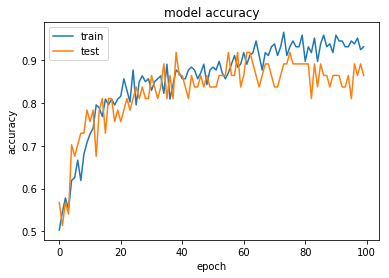

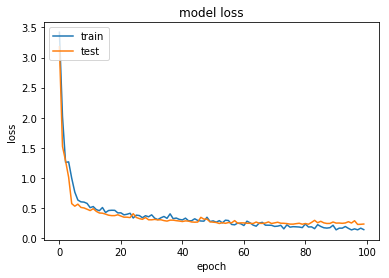

In [171]:
plotter(history)

In [173]:
model.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_139 (Conv1D)          (None, 91, 32)            1952      
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 45, 32)            0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 1440)              0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 1440)              0         
_________________________________________________________________
dense_128 (Dense)            (None, 650)               936650    
_________________________________________________________________
dropout_130 (Dropout)        (None, 650)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 2)               

### (low accuracy) training history of the CNN using positional values (71% average cross-val accuracy):

In [39]:
# build CNN model
model = models.Sequential()

model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(650, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0)

final epoch's metrics ~ 
	 loss  :  0.09682924406869071
	 accuracy  :  0.9659864
	 val_loss  :  0.539108768508241
	 val_accuracy  :  0.7297297


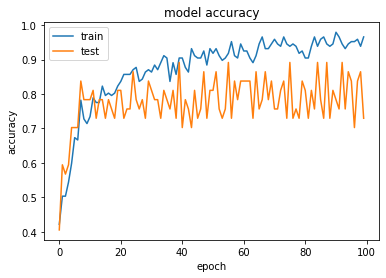

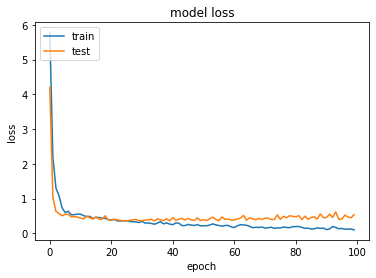

In [40]:
plotter(history)

# Conclusion

After testing all of these types of models, I noticed that the Strawman Approach (Logistic Regression) still performed the best! Although the first CNN (that utilized moving averages, and 6 channels of the different encodings (disorder, hydrophobicity, etc. in first 100aa) performed pretty similarly to the Strawman logistic regression approach. 

I noticed that the Strawman Approach also had more consistent accuracies, while the CNN varied a bit more. I'm hoping that this means the CNN is possibly more biologically relevant, which is to be expected since the positional values of protein sequence traits tend to matter a lot.

It's still surprising the me that the net averages work so well – I would've expected there to be too much noise there, and I'm curious if incorporating more features into the logistic regression classifier (i.e. splitting each of the 6 net average features into N-terminal and C-terminal net averages) would produce better results. Also, it might be worthwile trying to incorporate C-terminal values into the top performing CNN, to hopefully make up for any missing signals.

Regarding feature extraction, I tried using a few methods commonly used in keras, such as **visualize_cam** and **visualize_saliency**. These methods would essentially plot the **class activation heatmaps** for both effectors and non-effectors. It'd be useful to try this, and also try plotting the activation heatmaps on further clusters within both classes. They're usually 2 dimensional activation heatmaps, but in this case it'd be a single dimensional heatmap, that would *hopefully* show regions of the first 100 amino acids that are most important in the classification. This would be useful in using **MEME** to further search for motifs in these regions, from various subsets of the effector genes and hopefully find novel motifs.

I was focused on the best performing CNN, which most likely complicated things because it used 6 channels of the N-terminal amino acid encodings, and was using 1-dimensional convolutions. I believe these methods were mainly created for 2-dimensional convolutions, but there was also limited documentation (and the tensorflow/keras updates also complicated things). I'm planning to still try to debug more to try out these methods since they seem really interesting!

I also was looking at **DeepLift**, but since I was focused on the best performing CNN, it made things difficult because the model used 6 channels of the N-terminal amino acid encodings. I think **DeepLift** would've been more compatible to OneHot encoding approach, so that each encoding can actually be mapped to an amino acid. In my case, the encodings were somewhat all over the case, since they were moving averages and the positional encodings were still not unique to each amino acid. I've attached the encoding schemes in **FEAT.py**.

# (unsuccessful) feature extraction

In [33]:
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

layer_idx = utils.find_layer_idx(model, 'dense_5')
layer_idx

6

In [42]:
for class_idx in np.arange(2):    
    indices = np.where(y_train[:, class_idx] == 1.)[0]
    idx = indices[0]

# Swap softmax with linear
#model.layers[layer_idx].activation = activations.linear
#model = utils.apply_modifications(model)
grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_train[idx], backprop_modifier=None, penultimate_layer_idx=1)  

#grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_train[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

TypeError: gradients_v2() got an unexpected keyword argument 'colocate_gradients_with_ops'

In [ ]:
# This corresponds to the Dense linear layer.
for class_idx in np.arange(2):    
    indices = np.where(y_train[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_train[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_test[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

In [31]:
#visualize_cam(model, layer_idx, filter_indices, seed_input, penultimate_layer_idx=None, \
#    backprop_modifier=None, grad_modifier=None)
# This corresponds to the Dense linear layer.

for class_idx in np.arange(2): 
    indices = np.where(y_train[:, class_idx] == 1.)[0]
    idx = indices[0]


visualize_cam(model, layer_idx, filter_indices=class_idx, seed_input=x_train)

ValueError: Unable to determine penultimate `Conv` or `Pooling` layer for layer_idx: 6